# Imports

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from scipy.stats import ttest_ind, ttest_rel, ranksums, wilcoxon
import seaborn as sns

In [15]:
from backend import data_paths
from backend import evaluation_utils

# Load Return Period Metrics

In [16]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_v3_REANALYSIS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_v3_REANALYSIS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [17]:
from backend import data_paths
from backend import evaluation_utils
# from backend import gauge# Load Return Period Metrics

_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_v3_REANALYSIS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_v3_REANALYSIS_1980_RETURN_PERIOD_METRICS_DIR,
}

precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Calculate F1 Scores from Precision & Recall

In [18]:
f1s_by_lead_time = {
    dataset: {
        experiment: {
            lead_time:
              evaluation_utils.f1_from_precision_and_recall_dfs(
                  precision_df=precisions_by_lead_time[dataset][experiment][lead_time],
                  recall_df=recalls_by_lead_time[dataset][experiment][lead_time]
              ) for lead_time in data_paths.LEAD_TIMES
        } for experiment in precisions_by_lead_time[dataset]
    } for dataset in _DATASET_RETURN_PERIOD_METRICS_PATH
}

# Precision & Recall Distributions with Lead Time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2232726/453161101.py:37: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f646aea4c90> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_2232726/453161101.py:37: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f6468a6d510> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_2232726/453161101.py:37: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f6468a6de90> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_2232726/453161101.py:37: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f6468a6e710> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_2232726/453161101.py:37: UserWarning: The label '_' of <matplotlib.lines.Lin

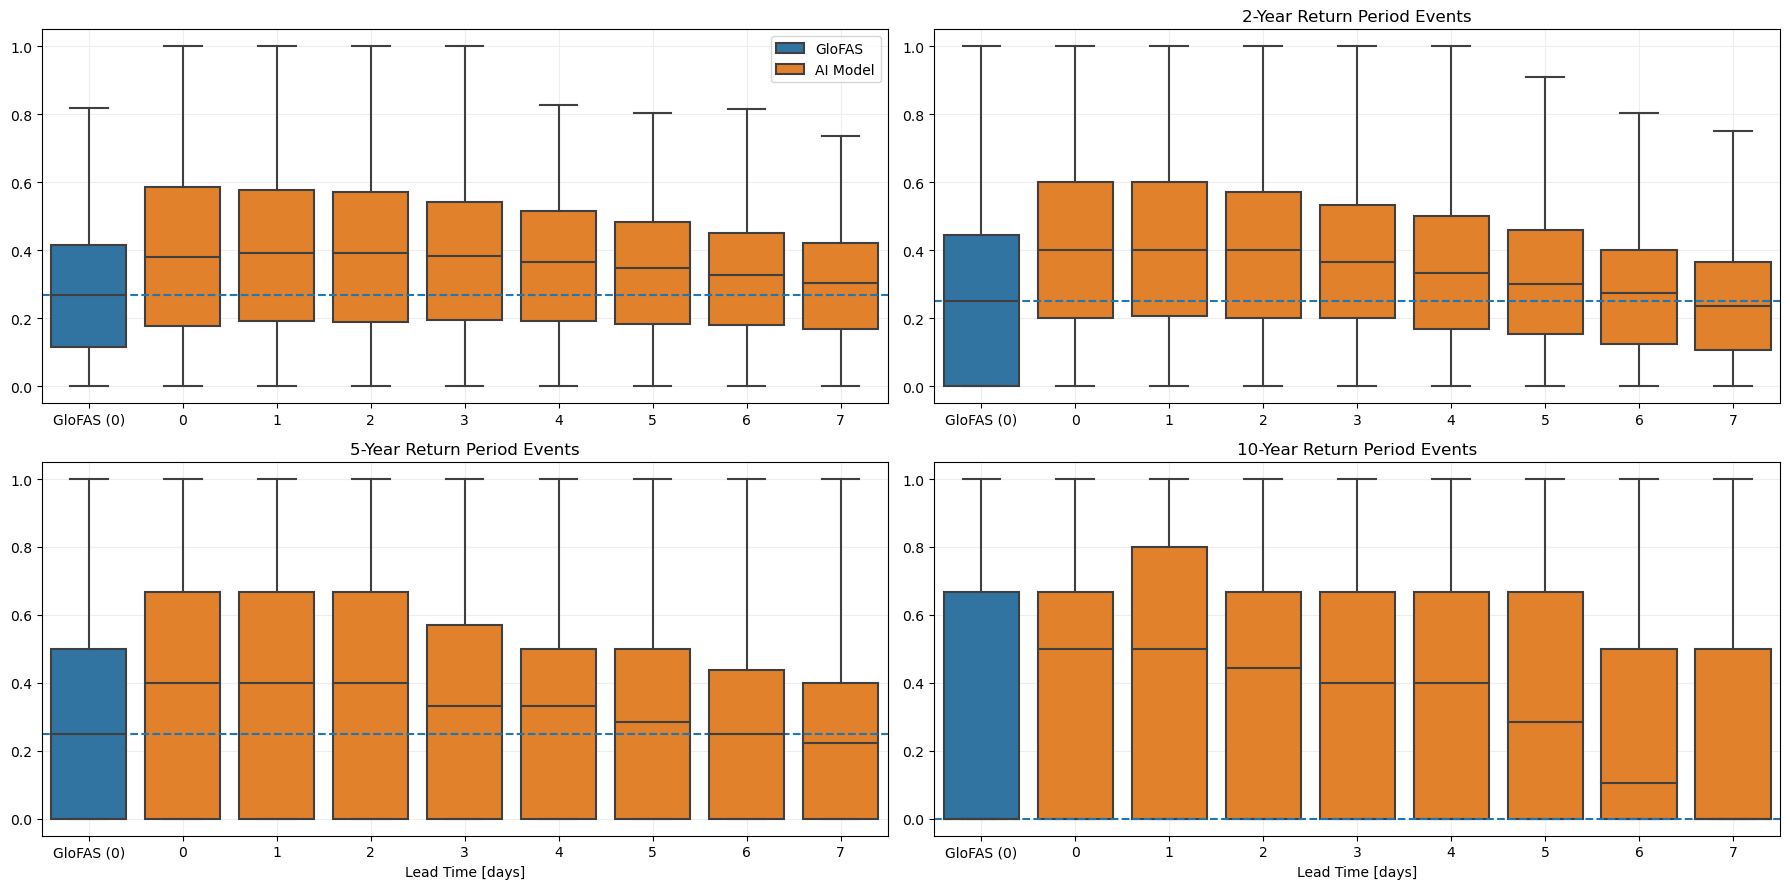

In [24]:
google_dataset = 'google_2014'
google_experiment = 'kfold_splits'
glofas_dataset = 'glofas_2014'
glofas_experiment = 'glofas_reanalysis'

fig, axes = plt.subplots(2, 2, figsize=(18, 9))

for ax, return_period in zip(axes.flatten(), evaluation_utils.RETURN_PERIODS[:-2]):

    # Plot GloFAS.
    dfs = [
        f1s_by_lead_time[glofas_dataset][glofas_experiment][0][return_period].rename(evaluation_utils.EXPERIMENT_NAMES[glofas_experiment])
    ]
    dfs = dfs + [
        f1s_by_lead_time[google_dataset][google_experiment][lead_time][return_period].rename(lead_time) for lead_time in data_paths.LEAD_TIMES
    ]
    df = pd.concat(dfs, axis=1).dropna()

    df.rename(columns={evaluation_utils.EXPERIMENT_NAMES[glofas_experiment]: 'GloFAS (0)'}, inplace=True)

    boxplot_colors = {'GloFAS (0)': evaluation_utils.COLORS[0]}
    boxplot_colors.update({lead_time: evaluation_utils.COLORS[1] for lead_time in data_paths.LEAD_TIMES})
    bp = sns.boxplot(ax=ax, data=df, showfliers=False, palette=boxplot_colors)
    ax.grid(c='#EEE')
    ax.set_axisbelow(True)
    if ax == axes[0, 0]:
        ax.legend(loc='upper right')
    else:
        ax.legend().remove()
        ax.set_title(f'{int(return_period)}-Year Return Period Events')
    if ax in axes[0, :]:
        ax.set_xlabel(None)
    else:
        ax.set_xlabel('Lead Time [days]')

    if ax == axes[0, 0]:
        ax.legend(
            [
                evaluation_utils.EXPERIMENT_NAMES[glofas_experiment]
            ] + ['_']*5 + [evaluation_utils.EXPERIMENT_NAMES[google_experiment],]
        )
    ax.plot(
        [-0.5, 8.5],
        [df['GloFAS (0)'].median()]*2,
        c=evaluation_utils.COLORS[0],
        ls='--'
    )

plt.tight_layout()

evaluation_utils.save_figure(data_paths.LEAD_TIME_RELIABILITY_DISTRIBUTIONS_FILENAME)

# Statistical Significance of Differences with GloFAS

In [34]:
google_dataset = 'google_2014'
google_experiment = 'kfold_splits'
glofas_dataset = 'glofas_2014'
glofas_experiment = 'glofas_reanalysis'

for return_period in evaluation_utils.RETURN_PERIODS[:-2]:
    for lead_time in data_paths.LEAD_TIMES:

        dfs = []
        dfs = dfs + []
        df = pd.concat(
            [
                f1s_by_lead_time[glofas_dataset][glofas_experiment][0][return_period].rename(evaluation_utils.EXPERIMENT_NAMES[glofas_experiment]).rename('glofas'),
                f1s_by_lead_time[google_dataset][google_experiment][lead_time][return_period].rename(lead_time).rename('google')
            ], 
            axis=1
        ).dropna()

        print(f'--- {return_period = } --- {lead_time = } ------------------------------------')
        print('Mean Difference:', (df['glofas'] - df['google']).mean())
        print(ttest_ind(df['glofas'], df['google']))
        print(ttest_rel(df['glofas'], df['google']))
        print(ranksums(df['glofas'], df['google']))
        print(wilcoxon(df['glofas'], df['google']))
        print('---------------------------------------------------------------------\n')

--- return_period = 1.01 --- lead_time = 0 ------------------------------------
Mean Difference: -0.10929807877975087
Ttest_indResult(statistic=-17.27161904131701, pvalue=7.977310662589853e-65)
TtestResult(statistic=-28.03942374644069, pvalue=3.516313217028182e-149, df=2314)
RanksumsResult(statistic=-15.566996338528304, pvalue=1.2200334326385405e-54)
WilcoxonResult(statistic=458856.0, pvalue=2.3331835275480692e-142)
---------------------------------------------------------------------

--- return_period = 1.01 --- lead_time = 1 ------------------------------------
Mean Difference: -0.11399512183985085
Ttest_indResult(statistic=-18.264176021657637, pvalue=5.16125846030363e-72)
TtestResult(statistic=-29.678921964935476, pvalue=2.8226386693824007e-164, df=2311)
RanksumsResult(statistic=-16.69465523793509, pvalue=1.4334479874958826e-62)
WilcoxonResult(statistic=432450.0, pvalue=1.6168078656729678e-155)
---------------------------------------------------------------------

--- return_period